In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('/Users/arvindsuresh/Documents/Github/Election-prediction-May-2025')

from src.utils import mixed_correlation_matrix, WeightedStandardScaler

years = [2008, 2012, 2016, 2020]
df = pd.read_csv('../data/processed_data/probability_dataset.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12224 entries, 0 to 12223
Data columns (total 60 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   gisjoin                             12224 non-null  object 
 1   year                                12224 non-null  int64  
 2   state                               12224 non-null  object 
 3   county                              12224 non-null  object 
 4   P(C)                                12224 non-null  float64
 5   P(house_in_C)                       12224 non-null  float64
 6   P(area_in_C)                        12224 non-null  float64
 7   median_household_income             12224 non-null  int64  
 8   per_capita_income                   12224 non-null  int64  
 9   population_density                  12224 non-null  float64
 10  P(income_10k_to_15k|house_in_C)     12224 non-null  float64
 11  P(income_15k_to_25k|house_in_C)     12224

In [4]:
import numpy as np
import pandas as pd

def mixed_correlation_matrix(df, columns=None, method_lower='pearson', method_upper='spearman', truncate_to=None):
    """
    Compute a correlation matrix where the lower triangle uses one method (default: Pearson)
    and the upper triangle uses another method (default: Spearman).
    
    Parameters:
    df (pd.DataFrame): The input dataframe.
    columns (list, optional): List of columns to include in the correlation. If None, uses all numeric columns.
    method_lower (str): Correlation method for the lower triangle ('pearson' or 'spearman').
    method_upper (str): Correlation method for the upper triangle ('pearson' or 'spearman').
    truncate_to (int, optional): Number of decimal places to round the correlations to. If None, no rounding is applied.
    
    Returns:
    pd.DataFrame: The mixed correlation matrix.
    """
    if columns is None:
        # Select numeric columns if not specified
        columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Compute full correlation matrices
    corr_lower = df[columns].corr(method=method_lower)
    corr_upper = df[columns].corr(method=method_upper)
    
    # Create a copy of the lower method matrix
    corr_mixed = corr_lower.copy()
    
    # Get the upper triangle mask (excluding diagonal)
    upper_mask = np.triu(np.ones_like(corr_mixed, dtype=bool), k=1)
    
    # Replace upper triangle with the upper method values using NumPy for direct assignment
    corr_mixed.values[upper_mask] = corr_upper.values[upper_mask]
    
    # Apply rounding if truncate_to is specified
    if truncate_to is not None:
        corr_mixed = corr_mixed.round(truncate_to)
    
    return corr_mixed

In [5]:
id_cols = df.columns[:4].tolist()
target_cols = df.columns[-7:].tolist()
feature_cols = df.columns[4:-7].tolist()
all_cols = feature_cols + target_cols

# Compute mixed correlation matrix for each year
corr_by_year_dict = {
    year: mixed_correlation_matrix(
        df[df['year'] == year], 
        columns=all_cols,
        truncate_to=3) for year in years
    }

# take average of correlation matrices across years
avg_corr_matrix = sum(corr_by_year_dict.values()) / 4

# truncate to 3 decimal places
avg_corr_matrix = avg_corr_matrix.round(3)

# save to csv
avg_corr_matrix.to_csv('../data/processed_data/correlation_mixed_average.csv', index=True)

In [ ]:
def plot_corr_heatmap(df_corr: pd.DataFrame, title: str):
    """
    Plot the correlation heatmap from a given correlation matrix DataFrame.
    """
    cell_width = 0.5
    cell_height = 0.65
    box_width = cell_width * avg_corr_matrix.shape[0]
    box_height = cell_height * avg_corr_matrix.shape[1]

    fig = plt.figure(figsize=(box_width, box_height))
    ax = sns.heatmap(
        avg_corr_matrix,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        center=0,
        vmin=-1, vmax=1,
        square=False,
        linewidths=0.5,
        cbar_kws={'shrink': 0.8, 'label': 'Correlation'}
    )
    plt.title(title, fontsize=14, fontweight='bold', pad=20)

    # Mirror the tick labels on top and right, with correct orientation
    ax.tick_params(
        labeltop=True, 
        labelbottom=True,
        labelright=True,
        labelleft=True
        )
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        label.set_horizontalalignment('center')
    for label in ax.get_yticklabels():
        label.set_rotation(0)
        label.set_verticalalignment('center')

    # Add space in between heatmap and color bar
    ax.figure.subplots_adjust(right=2.0)

    # plt.tight_layout()
    plt.show()

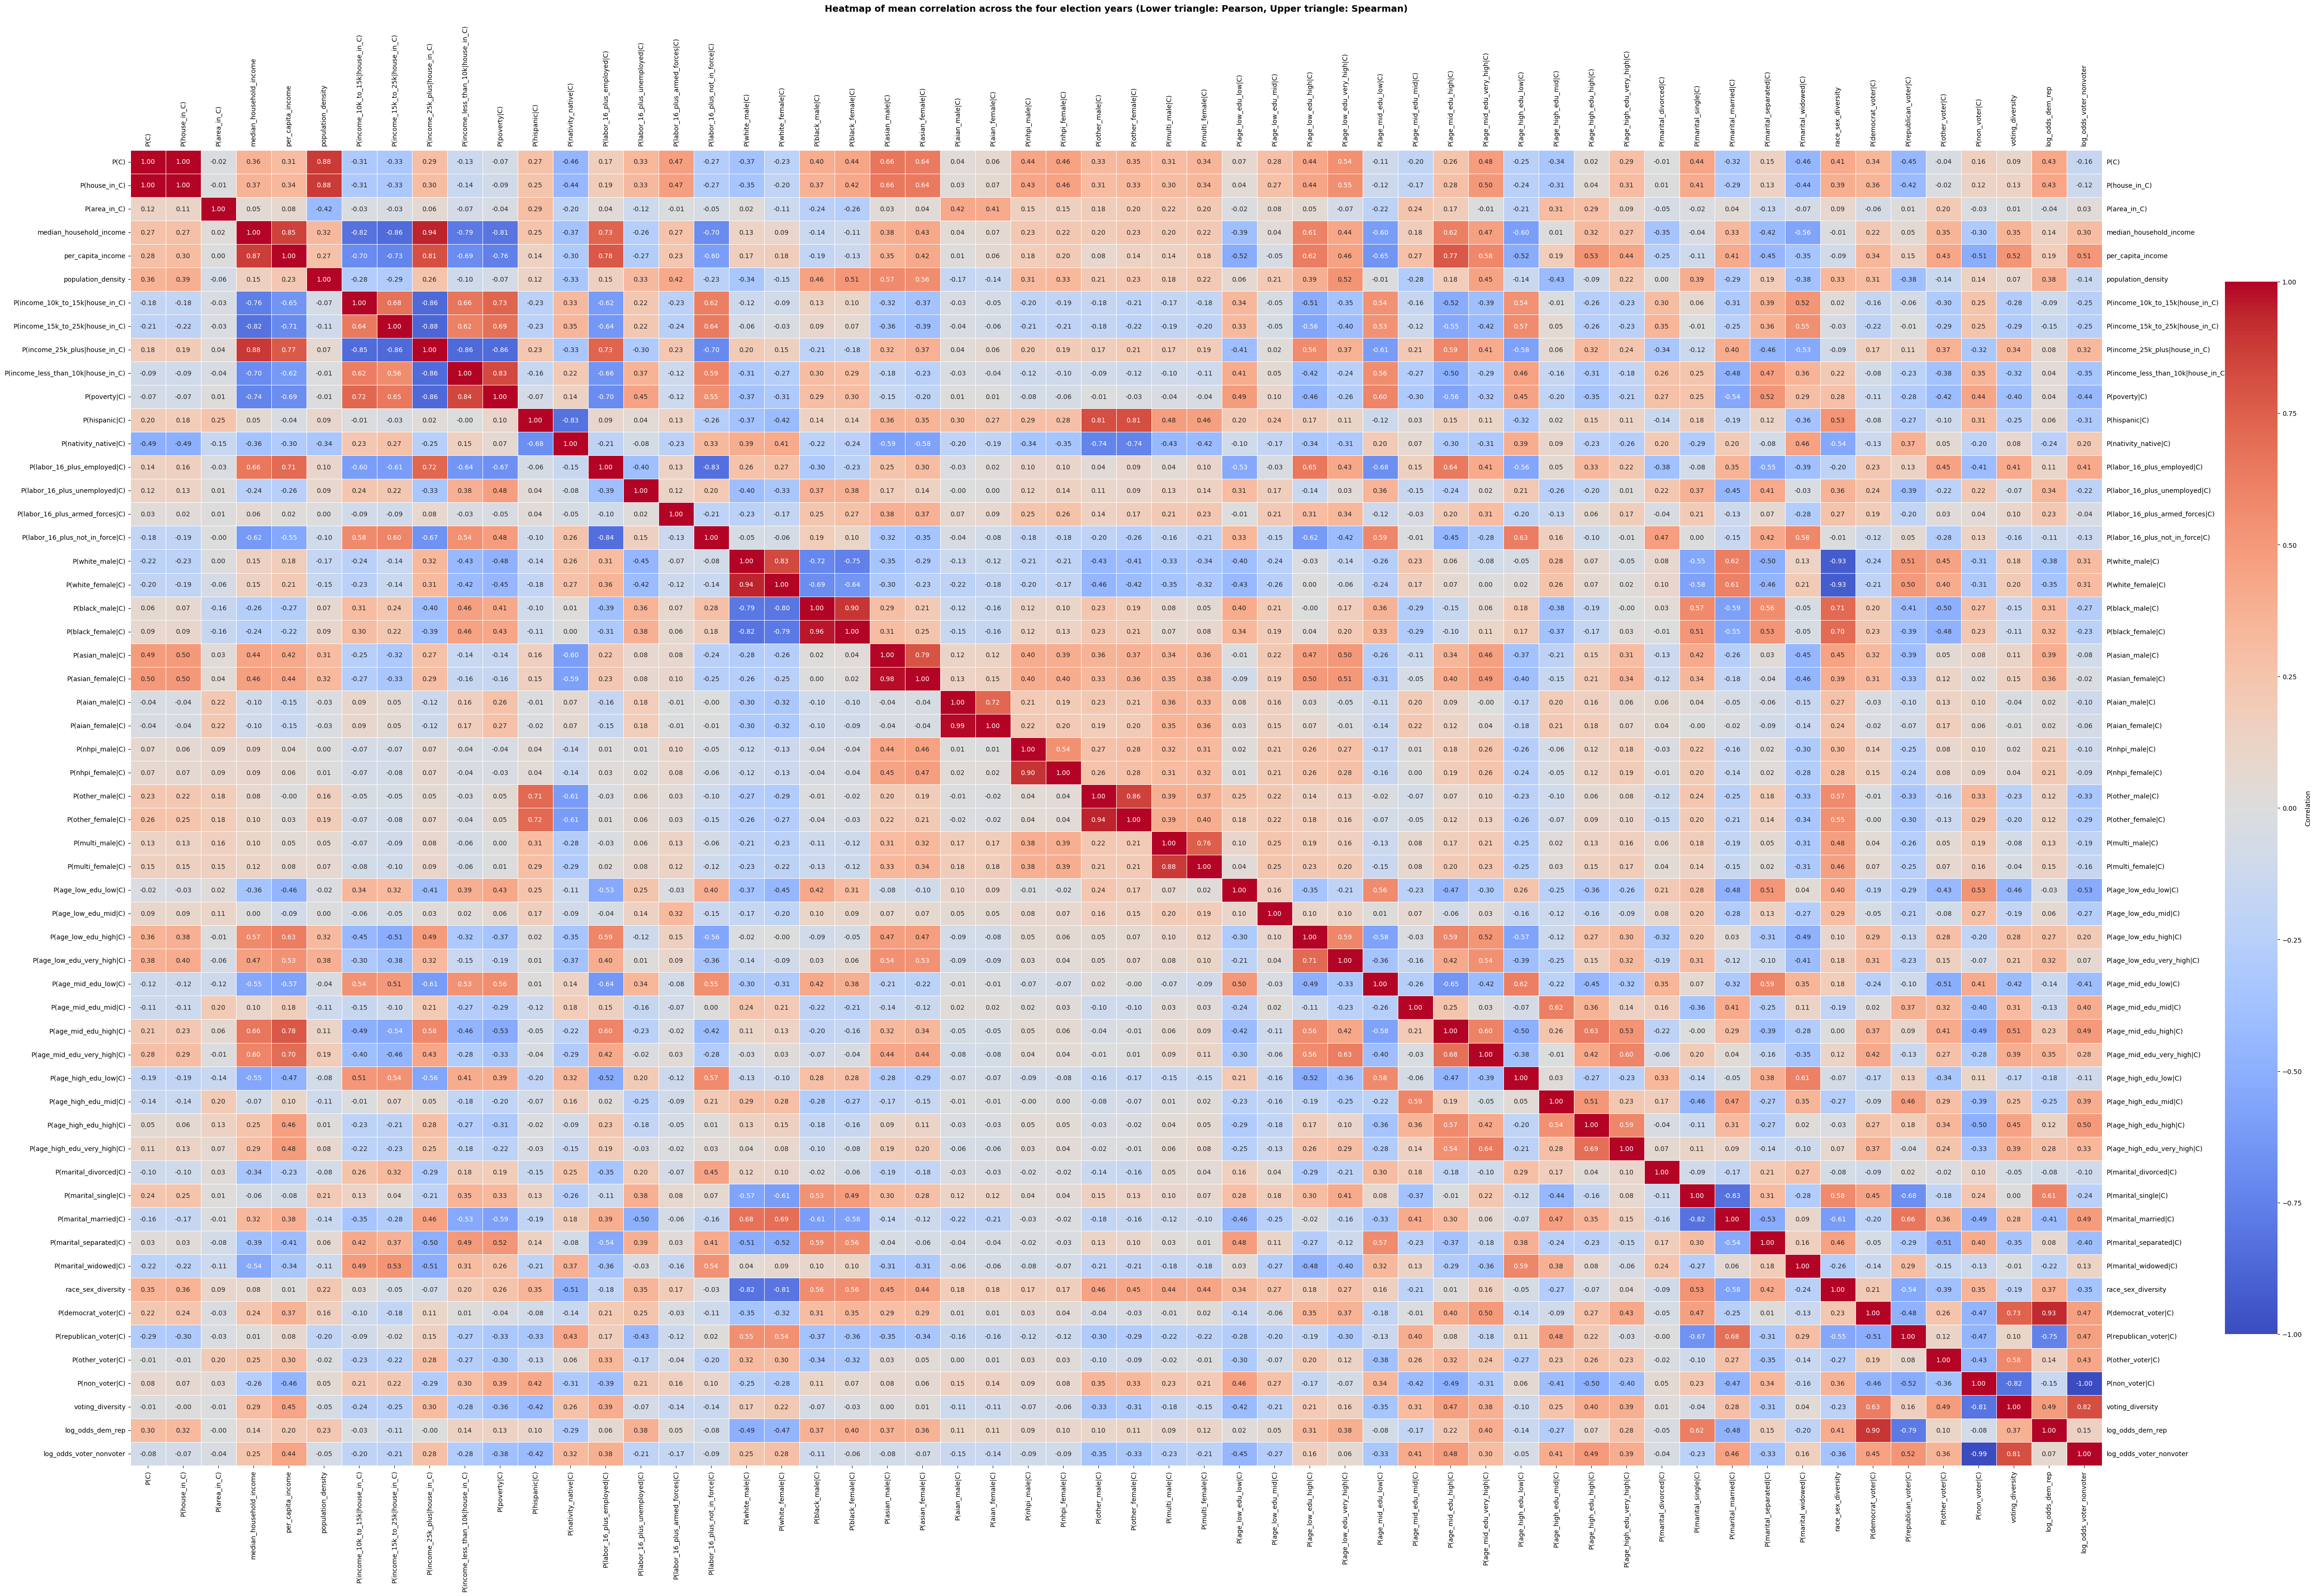

In [ ]:
# Plot the average mixed correlation matrix as a heatmap
cell_width = 0.5
cell_height = 0.65
box_width = cell_width * avg_corr_matrix.shape[0]
box_height = cell_height * avg_corr_matrix.shape[1]

fig = plt.figure(figsize=(box_width, box_height))
ax = sns.heatmap(
    avg_corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    vmin=-1, vmax=1,
    square=False,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8, 'label': 'Correlation'}
)
plt.title('Heatmap of mean correlation across the four election years (Lower triangle: Pearson, Upper triangle: Spearman)', fontsize=14, fontweight='bold', pad=20)
# plt.xlabel('Columns', fontsize=12, fontweight='bold')
# plt.ylabel('Rows', fontsize=12, fontweight='bold')
# plt.xticks(rotation=45, ha='right')
# plt.yticks(rotation=0)

# Mirror the tick labels on top and right, with correct orientation
ax.tick_params(
    labeltop=True, 
    labelbottom=True,
    labelright=True,
    labelleft=True
    )
for label in ax.get_xticklabels():
    label.set_rotation(90)
    label.set_horizontalalignment('center')
for label in ax.get_yticklabels():
    label.set_rotation(0)
    label.set_verticalalignment('center')

# Add space in between heatmap and color bar
ax.figure.subplots_adjust(right=2.0)

# plt.tight_layout()
plt.show()

## Summary of Averaged Feature & Target Correlations

This analysis is based on a correlation matrix averaged across four election years (2008, 2012, 2016, 2020). The top-right half of the matrix represents Spearman's rank correlation (ρ) and the bottom-left represents Pearson's correlation (r). Observations primarily reference Spearman correlations for robustness.

### Part 1: Inter-Feature Relationships

#### Key Feature Clusters

**1. Socio-Economic Status (SES) / Affluence Cluster:** A tightly coupled group of features describing county prosperity.
   - **Core Income Features:** `median_household_income` and `per_capita_income` are strongly correlated (ρ=0.86). `P(income_25k_plus|house_in_C)` acts as a strong proxy for income (ρ ≈ 0.95 with `median_household_income`).
   - **Positive Correlates (Markers of Affluence):**
     - **Education:** Higher education is strongly linked to income. `per_capita_income` correlates with `P(age_mid_edu_very_high|C)` at ρ=0.58.
     - **Employment:** `P(labor_16_plus_employed|C)` is strongly correlated with income (ρ=0.78 with `per_capita_income`).
     - **Marital Status:** `P(marital_married|C)` correlates positively with income (ρ=0.41 with `per_capita_income`).
   - **Negative Correlates (Markers of Poverty):**
     - **Poverty:** `P(poverty|C)` is strongly negatively correlated with income (ρ=-0.81 with `median_household_income`).
     - **Low Income / Education:** Low income brackets (e.g., `P(income_less_than_10k|house_in_C)`) and low educational attainment (e.g., `P(age_mid_edu_low|C)`) show strong negative correlations with the SES cluster.

**2. Racial, Ethnic & Nativity Cluster:** Features describing demographic composition, highlighting patterns of segregation.
   - **Racial Composition:** `P(white_male|C)` is strongly negatively correlated with `P(black_male|C)` (ρ=-0.72) and `P(hispanic|C)` (ρ=-0.43).
   - **Hispanic Identity:** `P(hispanic|C)` is very strongly correlated with `P(other_male|C)` (ρ=0.81), indicating individuals of Hispanic ethnicity often select "Other" for race.
   - **Nativity:** `P(nativity_native|C)` shows a very strong negative correlation with `P(hispanic|C)` (ρ=-0.68), suggesting immigration is a primary driver of Hispanic population concentration.
   - **Diversity Metric:** The engineered `race_sex_diversity` feature is almost perfectly negatively correlated with the proportion of the white population (ρ=-0.93 with `P(white_male|C)`), making it a direct measure of non-whiteness.

**3. Urbanicity Cluster:**
   - **Core Features:** `P(C)` (county population weight) and `population_density` are highly correlated (ρ=0.88).
   - **Correlates:** Urbanicity is positively associated with `race_sex_diversity` (ρ=0.41), Asian population (`P(asian_male|C)`, ρ=0.66), and single residents (`P(marital_single|C)`, ρ=0.44). It is negatively associated with the white population (`P(white_male|C)`, ρ=-0.37).

---

### Part 2: Feature-Target Relationships

#### Target 1: Partisan Lean (`log_odds_dem_rep`)
*A positive correlation indicates a Democratic lean; a negative correlation indicates a Republican lean.*

**Top Positive Correlates (Pro-Democrat Features):**
- `P(marital_single|C)`: (ρ=0.62) - Strongest individual signal, likely a proxy for urban and diverse populations.
- `race_sex_diversity`: (ρ=0.41) - Diverse counties strongly lean Democratic.
- `P(black_male|C)`: (ρ=0.41) - High Black population is a strong indicator.
- `P(age_mid_edu_very_high|C)`: (ρ=0.48) - Highly educated, working-age populations are a key Democratic constituency.
- `population_density`: (ρ=0.23) - Urban counties lean Democratic.

**Top Negative Correlates (Pro-Republican Features):**
- `P(white_male|C)`: (ρ=-0.51) - The strongest signal for Republican lean is a high white population.
- `P(marital_married|C)`: (ρ=-0.41) - High marriage rates correlate with Republican voting.
- `P(nativity_native|C)`: (ρ=-0.29) - Counties with more native-born residents lean Republican.

#### Target 2: Voter Turnout (`log_odds_voter_nonvoter`)
*A positive correlation indicates higher voter turnout; a negative correlation indicates lower turnout.*

**Top Positive Correlates (High Turnout Features):**
- `P(age_high_edu_high|C)`: (ρ=0.45) - Highly educated older populations show the strongest turnout.
- `per_capita_income`: (ρ=0.44) - Wealthier counties have higher turnout.
- `P(marital_married|C)`: (ρ=0.45) - Higher marriage rates correlate with higher civic participation.
- `P(labor_16_plus_employed|C)`: (ρ=0.38) - High employment correlates with high turnout.

**Top Negative Correlates (Low Turnout Features):**
- `P(poverty|C)`: (ρ=-0.38) - Poverty is a strong indicator of low turnout.
- `P(hispanic|C)`: (ρ=-0.42) - High Hispanic populations correlate strongly with lower overall turnout, likely due to citizenship status and other barriers.
- `P(marital_single|C)`: (ρ=-0.23) - High proportion of single residents correlates with lower turnout.
- `P(age_mid_edu_low|C)`: (ρ=-0.41) - Low educational attainment is a key marker for low participation.

---

### Part 3: Key Discrepancies between Pearson & Spearman Correlations

Comparing Pearson (r) and Spearman (ρ) correlations is a powerful diagnostic tool. A significant difference between the two for a given pair of variables often indicates the presence of major outliers or a distinctly non-linear relationship. For this dataset, the primary story told by these discrepancies is how a small number of extremely dense, populous, and unique urban counties can skew linear models, and how Spearman's rank correlation provides a more robust view of the trend across the entire range of counties.

**1. Population Density vs. Racial Demographics**

- **Pair:** `population_density` & `P(black_male|C)`
- **Correlations:** Pearson r ≈ 0.46, Spearman ρ ≈ 0.07
- **Observation:** A massive discrepancy. Pearson suggests a moderate positive relationship, while Spearman indicates virtually no relationship exists.
- **Hypothesis:** This is a classic case of **influential outliers**. A few counties (e.g., New York County, Philadelphia County, various counties in the DC metro area) have both extremely high population density and large Black populations. These few points exert enormous leverage on the linear regression line, creating a positive Pearson correlation. However, across the vast majority of America's counties, there is no consistent monotonic relationship. Spearman, by converting to ranks, dramatically down-weights the influence of these extreme outliers and reveals that for most counties, an increase in density does not imply an increase in the Black population share.

- **Pair:** `population_density` & `P(asian_male|C)`
- **Correlations:** Pearson r ≈ 0.57, Spearman ρ ≈ 0.31
- **Observation:** Both are positive, but Pearson's correlation is substantially stronger.
- **Hypothesis:** This is a similar, though less extreme, version of the above. Asian populations are also heavily concentrated in a few very dense urban and suburban counties. These outliers pull the linear fit upwards. The fact that the Spearman correlation is still moderately positive (0.31) suggests that the relationship is more widespread than with the Black population, but it is still highly non-linear and heavily skewed by the most extreme-density counties.

**2. Income vs. Partisan Lean**

- **Pair:** `per_capita_income` & `log_odds_dem_rep` (Democratic Lean)
- **Correlations:** Pearson r ≈ 0.23, Spearman ρ ≈ 0.34
- **Observation:** Spearman's correlation is significantly stronger than Pearson's.
- **Hypothesis:** This points to a **non-linear relationship**. The connection between income and voting is not a straight line. A plausible explanation is that as income increases, counties tend to become more Democratic, but the effect is not uniform. The relationship is likely stronger at the lower and middle ends of the income spectrum. Furthermore, some of the absolute wealthiest counties in the nation (e.g., affluent suburbs) are highly educated and have trended strongly Democratic, creating a "hook" at the top end of the income distribution that weakens a purely linear fit. Spearman captures the general monotonic trend ("richer is often more Democratic") more effectively by ignoring the specific shape of this curve.

**3. Social Demographics vs. Partisan Lean**

- **Pair:** `P(marital_single|C)` & `log_odds_dem_rep` (Democratic Lean)
- **Correlations:** Pearson r ≈ 0.44, Spearman ρ ≈ 0.62
- **Observation:** Spearman reveals a much stronger relationship than Pearson.
- **Hypothesis:** This suggests a **saturating non-linear effect**. An increase in the single population from 15% to 25% might correspond to a large increase in Democratic lean. However, an increase from 40% to 50% (in a county that is already a bastion for single residents) might have a smaller marginal effect. The relationship is consistently positive, but it flattens out at the extremes. This non-linearity weakens the Pearson correlation, while Spearman's rank-based method correctly identifies it as one of the most consistent and powerful monotonic predictors in the entire dataset.

---

**Overall Conclusion:** The frequent and large discrepancies, where Spearman's ρ is often a more intuitive and stronger measure than Pearson's r, strongly suggest that **linear models may struggle to capture the full complexity of these relationships.** The data is characterized by non-linear effects and influential outliers, making rank-based methods and models robust to these features (like tree-based models) potentially more effective.

In [16]:
from src.data_handling import WeightedStandardScaler
import pandas as pd
import numpy as np

# --- Helper Function for Weighted Correlation ---

def weighted_correlation_matrix(df: pd.DataFrame, weights: np.ndarray, method: str = 'pearson') -> pd.DataFrame:
    """
    Computes a weighted correlation matrix for the given method.
    """
    if method == 'spearman':
        df_ranked = df.rank()
        return weighted_correlation_matrix(df_ranked, weights, method='pearson')

    X = df.values
    w = weights.flatten()
    
    # Calculate weighted means
    w_sum = np.sum(w)
    mean = np.sum(X * w[:, np.newaxis], axis=0) / w_sum
    
    # Calculate weighted covariance
    centered_X = X - mean
    cov = (centered_X.T @ (centered_X * w[:, np.newaxis])) / w_sum
    
    # Calculate weighted standard deviations and correlation
    std_dev = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std_dev, std_dev)
    
    return pd.DataFrame(corr, index=df.columns, columns=df.columns)

def mixed_weighted_correlation_matrix(df: pd.DataFrame, weights: np.ndarray) -> pd.DataFrame:
    """
    Computes a mixed correlation matrix using weighted correlations.
    Lower triangle: Pearson, Upper triangle: Spearman.
    """
    corr_lower = weighted_correlation_matrix(df, weights, method='pearson')
    corr_upper = weighted_correlation_matrix(df, weights, method='spearman')
    
    corr_mixed = corr_lower.copy()
    upper_mask = np.triu(np.ones_like(corr_mixed, dtype=bool), k=1)
    corr_mixed.values[upper_mask] = corr_upper.values[upper_mask]
    
    return corr_mixed

# 1. Define columns to process
cols_to_process = df.columns[7:].tolist()

# 2. Scale data and compute yearly weighted correlation matrices
yearly_correlations = []
for year in years:
    year_df = df[df['year'] == year]
    
    # Prepare data for the current year
    weights = year_df['P(C)'].values
    features_df = year_df[cols_to_process]
    
    # Scale the data for the current year
    scaler = WeightedStandardScaler()
    scaled_features_np = scaler.fit_transform(features_df.values, weights)
    scaled_features_df = pd.DataFrame(scaled_features_np, columns=cols_to_process)
    
    # Compute the mixed weighted correlation matrix for the scaled data
    corr_matrix = mixed_weighted_correlation_matrix(scaled_features_df, weights)
    yearly_correlations.append(corr_matrix)

# 3. Average the yearly matrices
avg_corr_matrix_scaled = pd.DataFrame(
    np.mean([m.values for m in yearly_correlations], axis=0),
    columns=yearly_correlations[0].columns,
    index=yearly_correlations[0].index
)

# drop the 'year' row and column if present
if 'year' in avg_corr_matrix_scaled.index:
    avg_corr_matrix_scaled = avg_corr_matrix_scaled.drop(index='year', columns='year')

# Truncate to 3 decimal places
avg_corr_matrix_scaled = avg_corr_matrix_scaled.round(3)

# 4. Save the scaled averaged correlation matrix to CSV
avg_corr_matrix_scaled.to_csv('../data/processed_data/correlation_mixed_average_scaled.csv', index=True)

# # 4. Display the result
# print("Averaged Correlation Matrix (after Population-Weighted Scaling):")
# display(avg_corr_matrix_weighted_scaled.style.background_gradient(cmap='vlag', vmin=-1, vmax=1))

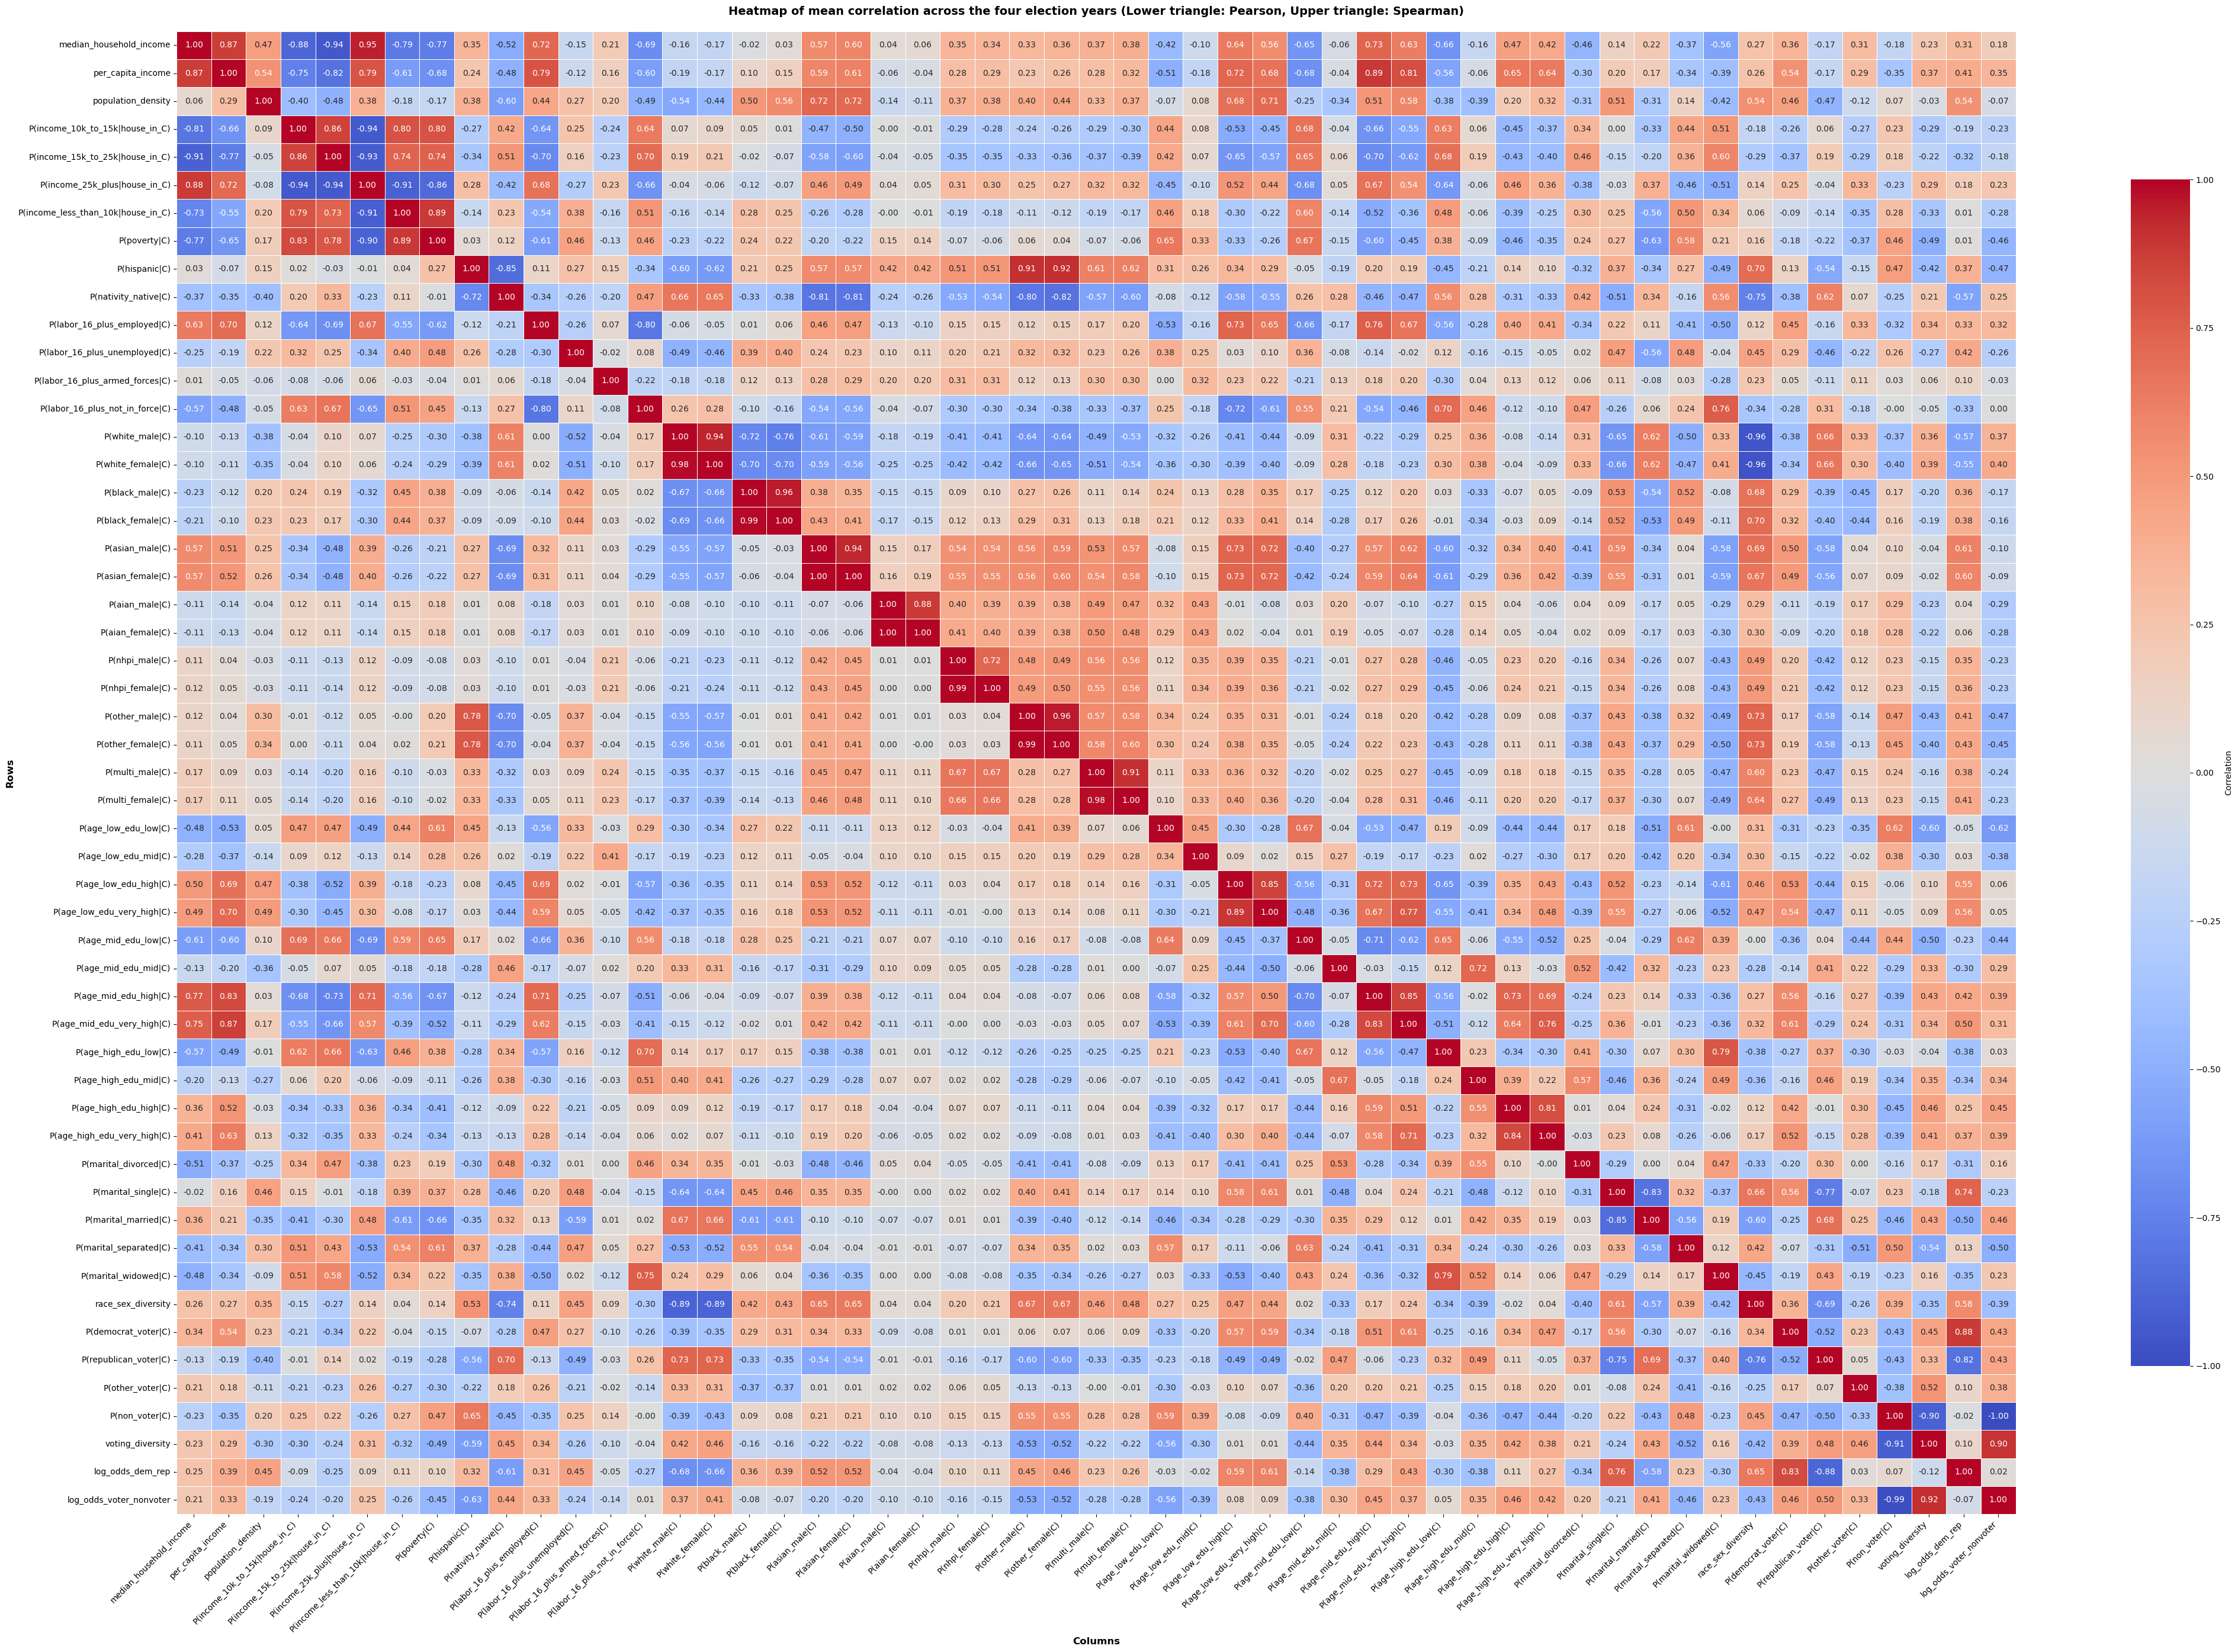

In [17]:
# Plot the new average mixed correlation matrix as a heatmap
cell_width = 0.75
cell_height = 0.5
box_width = cell_width * avg_corr_matrix.shape[0]
box_height = cell_height * avg_corr_matrix.shape[1]

fig = plt.figure(figsize=(box_width, box_height))
sns.heatmap(
    avg_corr_matrix_scaled,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    vmin=-1, vmax=1,
    square=False,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8, 'label': 'Correlation'}
)
plt.title('Heatmap of mean correlation across the four election years (Lower triangle: Pearson, Upper triangle: Spearman)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Columns', fontsize=12, fontweight='bold')
plt.ylabel('Rows', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# from src.data_handling import WeightedStandardScaler
# import pandas as pd
# import numpy as np

# # 1. Define columns to process
# cols_to_process = df.columns[7:].tolist()

# # 2. Scale data year-by-year using population weights
# scaled_dfs = []
# for year in df['year'].unique():
#     year_df = df[df['year'] == year].copy()
    
#     weights = year_df['P(C)'].values
#     data_to_scale = year_df[cols_to_process]
    
#     scaler = WeightedStandardScaler()
#     scaled_data = scaler.fit_transform(data_to_scale.values, weights)
    
#     scaled_year_df = pd.DataFrame(scaled_data, columns=cols_to_process)
#     scaled_year_df['year'] = year
#     scaled_dfs.append(scaled_year_df)

# scaled_df_all_years = pd.concat(scaled_dfs, ignore_index=True)

# # 3. Compute the averaged correlation matrix from the scaled data
# yearly_correlations = [
#     mixed_correlation_matrix(scaled_df_all_years[scaled_df_all_years['year'] == y]) 
#     for y in df['year'].unique()
# ]

# avg_corr_matrix_scaled = pd.DataFrame(
#     np.mean([m.values for m in yearly_correlations], axis=0),
#     columns=yearly_correlations[0].columns,
#     index=yearly_correlations[0].index
# )

# # drop the 'year' row and column if present
# if 'year' in avg_corr_matrix_scaled.index:
#     avg_corr_matrix_scaled = avg_corr_matrix_scaled.drop(index='year', columns='year')

# # Truncate to 3 decimal places
# avg_corr_matrix_scaled = avg_corr_matrix_scaled.round(3)

# # 4. Save the scaled averaged correlation matrix to CSV
# avg_corr_matrix_scaled.to_csv('../data/processed_data/correlation_mixed_average_scaled.csv', index=True)

# # # 5. Display the result
# # print("Averaged Correlation Matrix (after Population-Weighted Scaling):")
# # display(avg_corr_matrix_scaled.style.background_gradient(cmap='vlag', vmin=-1, vmax=1))

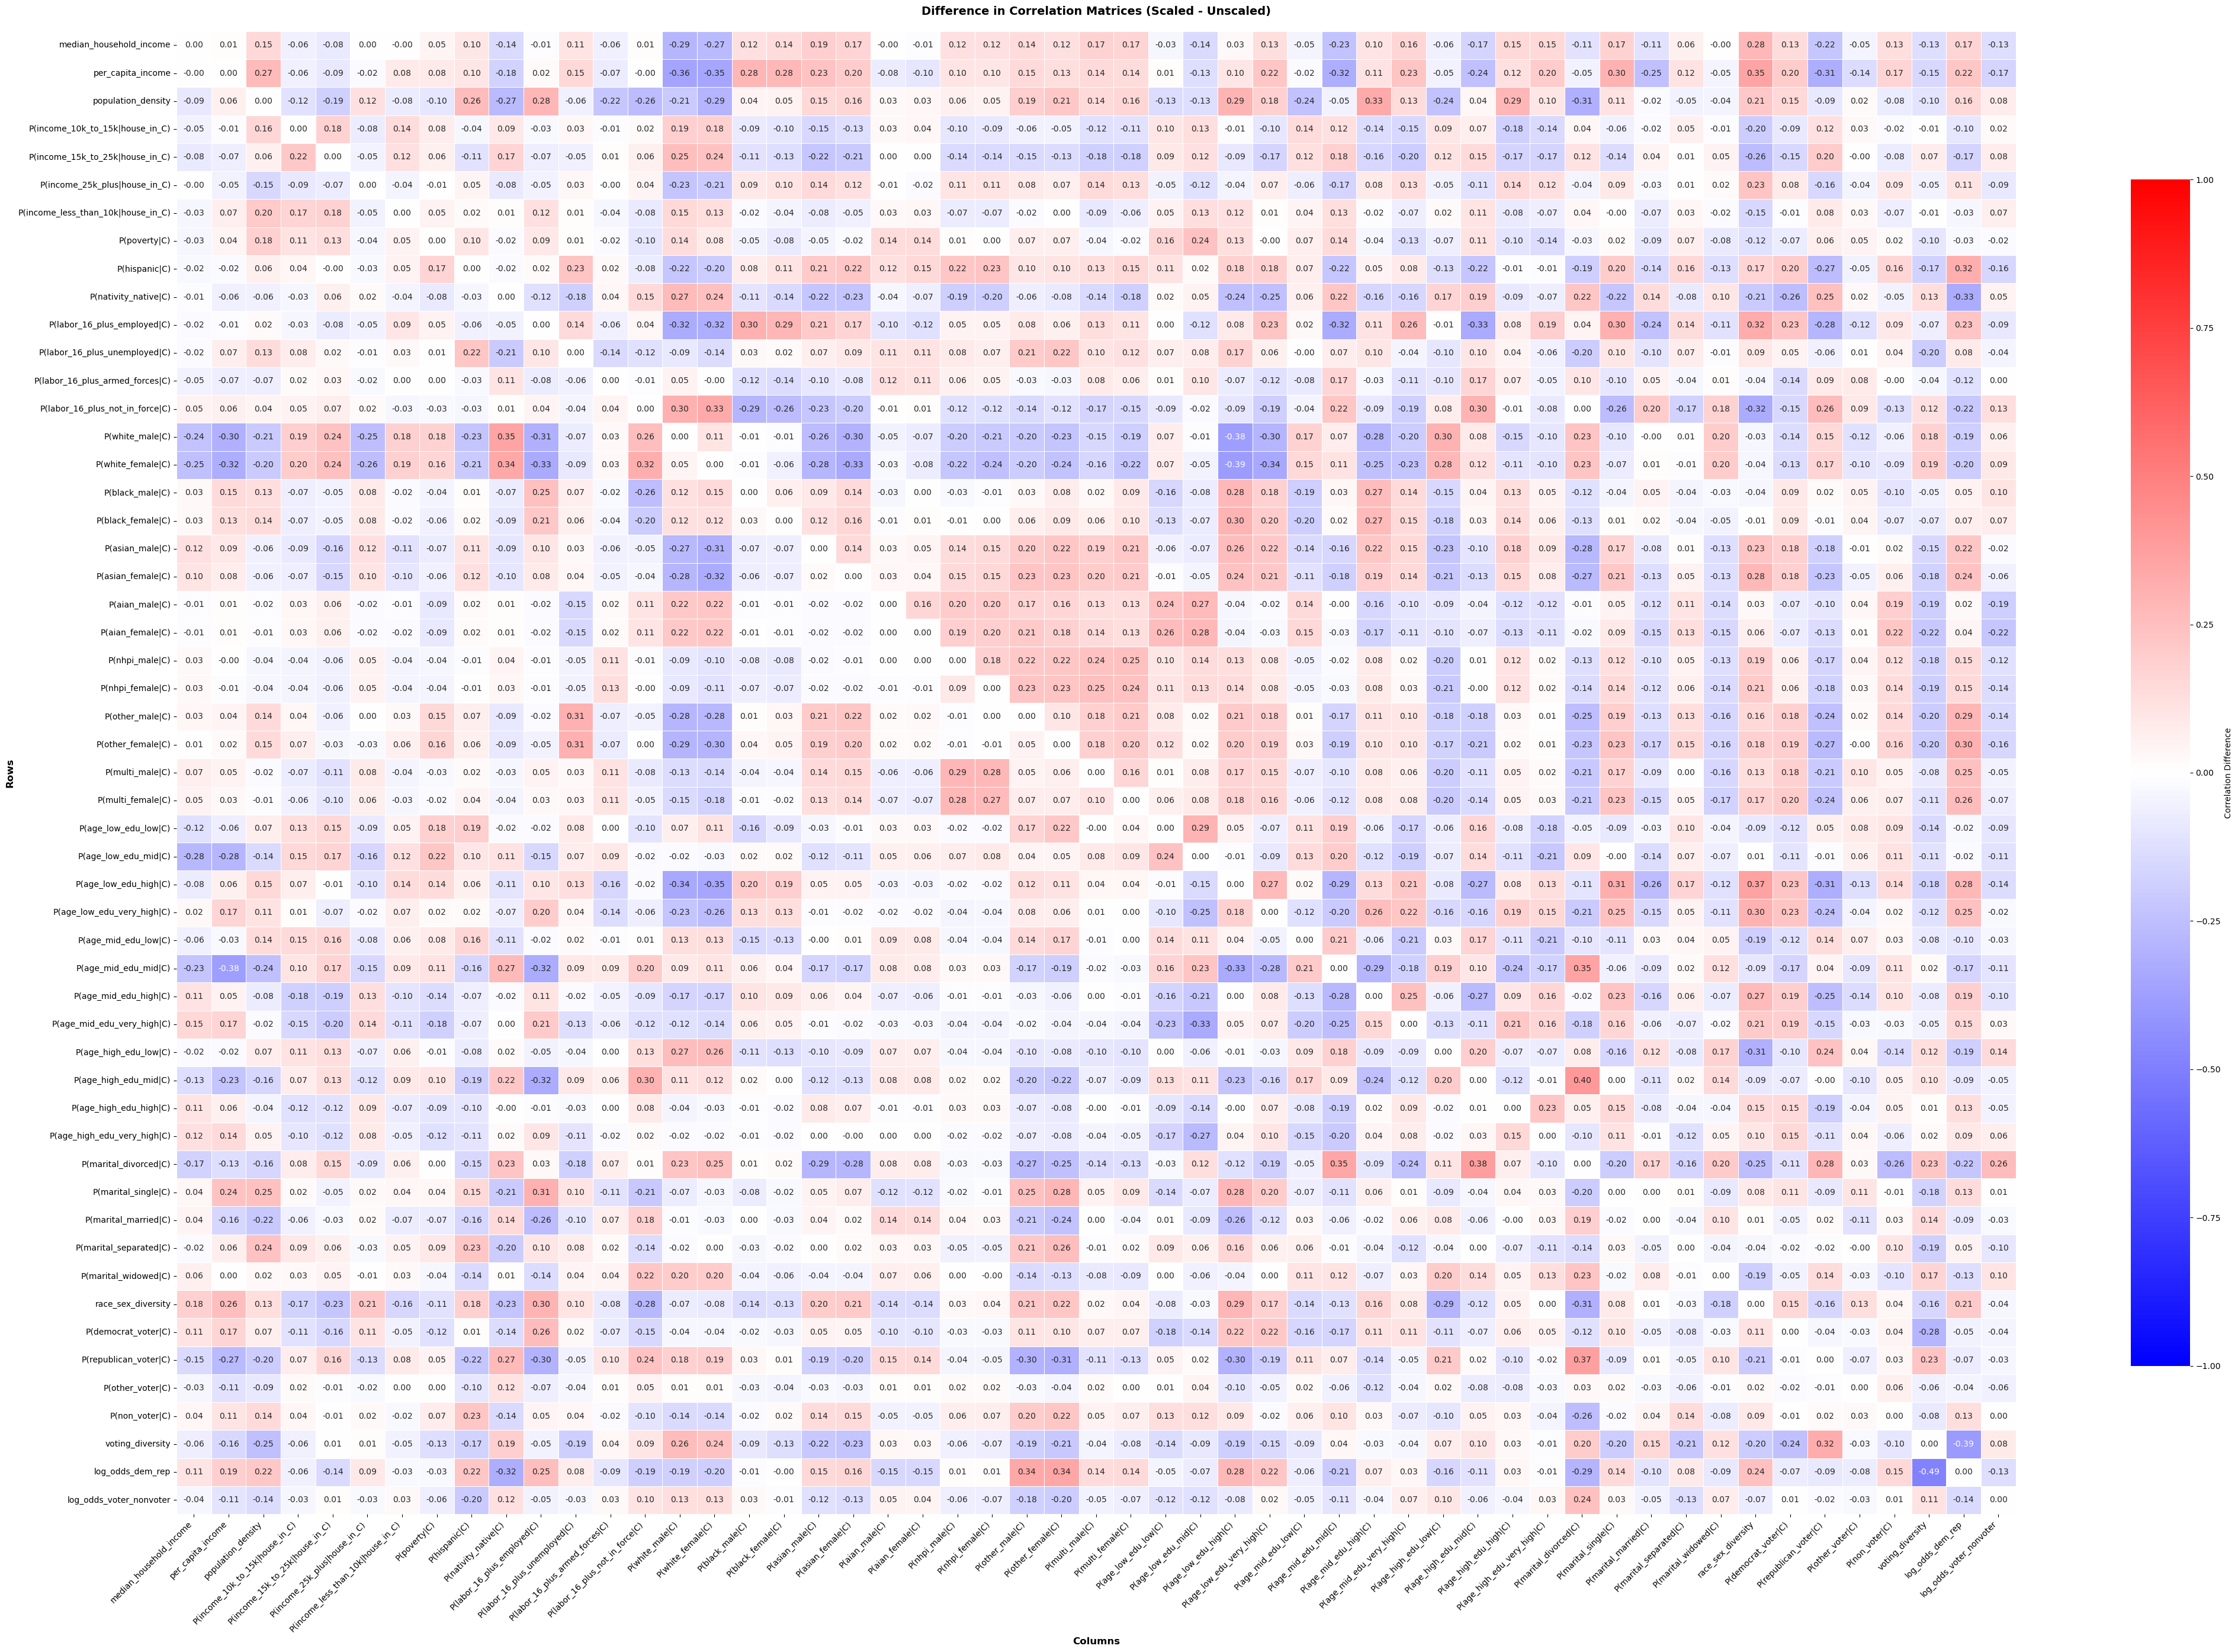

In [18]:
# get subset of avg_corr_matrix with columns[7:]
subset_avg_corr_matrix = avg_corr_matrix.loc[cols_to_process, cols_to_process]

# difference the two correlation matrices
difference_matrix = avg_corr_matrix_scaled - subset_avg_corr_matrix

# plot the difference matrix as a heatmap
fig = plt.figure(figsize=(box_width, box_height))
sns.heatmap(
    difference_matrix,
    annot=True,
    fmt=".2f",
    cmap='bwr',
    center=0,
    vmin=-1, vmax=1,
    square=False,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8, 'label': 'Correlation Difference'}
)
plt.title('Difference in Correlation Matrices (Scaled - Unscaled)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Columns', fontsize=12, fontweight='bold')
plt.ylabel('Rows', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [15]:
difference_matrix.to_csv('../data/processed_data/correlation_difference_scaled_vs_unscaled.csv', index=True)

# EDA of Demographic Features

This analysis explores the relationships between demographic features in the dataset. We examine two types of correlations:
1.  **Unweighted (County-Centric):** Each county is treated equally, providing a view of the "average county".
2.  **Weighted (Person-Centric):** Each county is weighted by its population (`P(C)`). This gives more influence to populous counties and provides a view reflecting the experience of the "average person".

Comparing these two views reveals key differences between urban and rural America.

---

### 1. The Urban vs. Rural Divide: Impact of Population Weighting

The biggest differences between the weighted and unweighted correlations highlight trends that are specific to large, populated areas.

#### 1.1. Population Density, Race, and Nativity
- **Density and Race:** The link between high population density and racial diversity is much stronger in the weighted data. The unweighted Pearson correlation between `population_density` and `P(white_male|C)` is -0.375, but the weighted correlation is -0.541. This shows that the pattern of dense areas being less white is driven primarily by large cities.
- **Nativity and Hispanic Population:** The negative correlation between the native-born population (`P(nativity_native|C)`) and the Hispanic population (`P(hispanic|C)`) is much stronger when weighted (-0.716 vs. -0.846). This indicates that counties with large immigrant populations are predominantly large urban centers.

#### 1.2. Economy and Education
- The connection between high income and high education is also stronger in the weighted view. The weighted Pearson correlation between `per_capita_income` and the population with a graduate degree (`P(age_mid_edu_very_high|C)`) is +0.813. This is higher than the unweighted value, suggesting that the concentration of high-earning, highly-educated people is a distinct feature of populous counties.

**Conclusion:** Population weighting amplifies the characteristics of urban America. Trends that become stronger with weighting are hallmarks of life in and around major cities.

---

### 2. Economic Profiles of Counties

The features cluster together to describe two opposite types of county economies.

#### 2.1. The Affluence Profile
- **Core Indicators:** `median_household_income`, `per_capita_income`, and `P(income_25k_plus|house_in_C)` are all very highly correlated with each other, forming the core of the affluence profile.
- **Key Correlates of High Income:**
    - **Education:** The strongest correlates with income are high levels of education. The proportion of the population aged 35-64 with a graduate degree (`P(age_mid_edu_very_high|C)`) has a Pearson correlation of +0.813 with `per_capita_income`.
    - **Employment:** A high proportion of the population being employed (`P(labor_16_plus_employed|C)`) is strongly correlated with income (+0.722 with `median_household_income`).
    - **Demographics:** A higher share of the Asian population (`P(asian_male|C)`) is positively correlated with `median_household_income` (+0.572).
    - **Family Structure:** A higher rate of marriage (`P(marital_married|C)`) is positively correlated with `median_household_income` (+0.411).

#### 2.2. The Economic Distress Profile
- **Core Indicators:** `P(poverty|C)` and low-income brackets (like `P(income_less_than_10k|house_in_C)`) are highly correlated.
- **Key Correlates of Poverty:**
    - **Low Education:** The strongest correlate is a lack of basic education. The proportion of the population aged 18-34 with less than a 9th-grade education (`P(age_low_edu_low|C)`) has a Pearson correlation of +0.650 with `P(poverty|C)`.
    - **Labor Status:** Poverty is correlated with both unemployment (`P(labor_16_plus_unemployed|C)`, +0.483) and, even more strongly, with people not being in the labor force at all (`P(labor_16_plus_not_in_force|C)`, +0.455).
    - **Family Structure:** The proportion of separated individuals (`P(marital_separated|C)`) has a high correlation with poverty (+0.584).

---

### 3. Social and Demographic Structures

#### 3.1. Marital Status
Marital status is closely linked to the economic and racial profiles of counties.
- **Marriage, Affluence, and Race:** Counties with higher marriage rates (`P(marital_married|C)`) tend to be wealthier and have higher proportions of White (+0.665 correlation with `P(white_male|C)`) and Asian residents.
- **Singlehood, Hardship, and Race:** Counties with more single (`P(marital_single|C)`) and separated (`P(marital_separated|C)`) individuals tend to have higher poverty and a larger Black population. The correlation between `P(marital_separated|C)` and `P(black_male|C)` is +0.553.
- **Widowhood and Age:** The share of the widowed population (`P(marital_widowed|C)`) is not primarily an economic indicator but a proxy for an older, retired population. It is highly correlated with the share of people not in the labor force (+0.581).

#### 3.2. Racial Demographics
- There is a very strong negative correlation between the share of the White population and the shares of Black and Hispanic populations.
- This negative relationship is stronger in the weighted data, which suggests that residential segregation at the county level is more pronounced in and around large, diverse cities.